# README

#### This Jupyter Notebook contains two CNNs.   

#### CNN #1: A Sequential CNN consisting of 6 trainable layers. This model is was developed by Diego Fernández.

#### CNN #2: A Sequential CNN that uses the VGG16 model, which consists of 16 trainable layers. The final Dense() layer has been removed and a substitute Dense() has been layer added in order to convert the model to a 3 class classifier. 



## Author's Contact Details
#### Emails:
fernandezd1998@gmail.com     
s1623786@ed.ac.uk
#### Phone Numbers: 
+44 7474047874     
+1 787-426-2312

Import statements and warning control (to ignore certain warnings)

In [1]:
#import statements
import os
import numpy as np
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import json
warnings.simplefilter(action ='ignore', category = FutureWarning)

import keras
from keras.preprocessing.image import ImageDataGenerator             #Used for formatting the image
from keras.models import Sequential                                  #Model Module
from keras.layers import Conv2D, MaxPooling2D                        #Convolution and Pooling CNN layers
from keras.layers import Activation, Dense, Dropout, Activation, Flatten, BatchNormalization   #Core layers
from keras import backend as K                       #Model level library. Optimized tensor operations. High-level
from keras.optimizers import Adam                    #Stochastic Gradient Descent Method
from keras.metrics import categorical_crossentropy   #Loss Function
from keras.preprocessing import image                #Used for pre-processing an image
from sklearn.metrics import confusion_matrix         #this is to help analyse the effectiveness of the model
import tensorflow as tf                              #there are some additional helpful functions in tensorflow

#np.random.seed(123)  # for reproducibility

Using TensorFlow backend.


#### The VGG16 library will be used to prepare images for the model. VGG16 image preparation is done by subtracting the mean RBG values from each pixel in the images. The VGG16 model is one of two CNNs that is used in this code
There are many other models that can be found here for future changes to the code:   
[Keras Models Library](https://keras.io/api/applications/)

In [2]:
from keras.applications import vgg16   

#### Check if your computer is using a GPU
Un-comment this section to see if your computer is using a GPU or multiple

In [3]:
#Not using GPU for Diego's computer
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print(len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

This is a confusion matrix plotting function from an old version of scikit learn. It has simply been copy-pasted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html .

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Directory Creation and File Relocation

## Here we move to the correct file directory
Make sure your files are all in one place and not in sub-folders. I find it helpful to have the class in the front of each file name (good, high, low) so that you can use 'high\*', 'good\*' or 'low*' in the arguments for glob.glob.     
For example: good_30_12_20_4_70.6_lossiemouth.bmp   
   
Make sure to have a copy of the folder before running any of the code below.   
Change data_dir to your file directory. 

In [5]:
data_dir = '/Users/Diego/Desktop/DIEGO CNN HANDOFF/The Code/All Images Correctly Labelled'  #insert correct directory
os.chdir(data_dir)
print(os.getcwd())

/Users/Diego/Desktop/DIEGO CNN HANDOFF/The Code/All Images Correctly Labelled


### Here we create the directories for train, validate and test

#### We have:      
Amount of good: 668 files   
Amount of high: 399 files   
Amount of low:  156 files

In [6]:
##### Creating the train, validate and test directories using os.makedirs #####

print(os.getcwd())    #making sure I am in the right directory

# os.makedirs('train/high')
# os.makedirs('train/good')
# os.makedirs('train/low')
# os.makedirs('validate/high')
# os.makedirs('validate/good')
# os.makedirs('validate/low')
# os.makedirs('test/high')
# os.makedirs('test/good')
# os.makedirs('test/low')

/Users/Diego/Desktop/DIEGO CNN HANDOFF/The Code/All Images Correctly Labelled


### Here we move the data into train, validate and test folders
*DO NOT ACCIDENTALLY RUN THIS TWICE!!!*   
Make sure to check each folder to ensure all the data is in the right place before moving on.

#### For this run we split the data into these amounts:   
Train Amount: 100 high good and low   
Validate Amount: 35 high, good and low (22% of total amount)     
Test Amount: 20 high, good and low (13% of total amount)

In [18]:
# We will use shutil.move to move the files instead of os.rename
# glob is used to select files in the current working directory that begin with high or good (hence the *)


# for x in random.sample(glob.glob('high*'), 100):
#     shutil.move(x, 'train/high')
# for x in random.sample(glob.glob('good*'), 100):
#     shutil.move(x, 'train/good')
# for x in random.sample(glob.glob('low*'), 100):
#     shutil.move(x, 'train/low')
# for x in random.sample(glob.glob('high*'), 35):
#     shutil.move(x, 'validate/high')
# for x in random.sample(glob.glob('good*'), 35):
#     shutil.move(x, 'validate/good')
# for x in random.sample(glob.glob('low*'), 35):
#     shutil.move(x, 'validate/low')
# for x in random.sample(glob.glob('high*'), 20):
#     shutil.move(x, 'test/high')
# for x in random.sample(glob.glob('good*'), 20):
#     shutil.move(x, 'test/good')
# for x in random.sample(glob.glob('low*'), 20):
#     shutil.move(x, 'test/low')

#### The path names saved as variables:
Make sure your current working directory is the one containing the test, validate and train folders. You can check this using os.getcwd()

In [20]:
train_dir = 'train'
validate_dir = 'validate'
test_dir = 'test'

# Preparing the Data

### Here we prepare the data so that it can be read by the Sequential model

#### Need to first select a resize image
Smaller dimensions means the code runs faster, but the model may not be as good.   
I will be using 224x224 because the vgg16 model uses this. But this can be changed, as will be explained later.

In [21]:
im_size = (224, 224)

#### We need to select the batch size
This avoids giving all the data points to the model at once.   
Batch size allows us to put chunks of the data in.   
Bigger batch size is better, but it may take a long time to run, with risk of over-fitting. 


Paper about batch size: https://arxiv.org/abs/1609.04836   

"It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize."

In [22]:
batch = 10      #so there would be 10 images in a batch

#### The actual image preprocessing
We have set classes = \['high', 'good'\], so an image labelled \[1,0\] will be high and \[0,1\] will be good

In [23]:
#.flow_from_directory allows us to iterate through the correct directory to re-format all the images
#vgg16.preprocess_input applies preprocessing on the images before being passed to the network. 
#It does not have to be based on the vgg16; choose another model if you want something different (link above).

train_batches = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input).flow_from_directory(
    directory = train_dir, target_size = im_size, classes = ['high', 'good', 'low'], batch_size = batch)
validate_batches = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input).flow_from_directory(
    directory = validate_dir, target_size = im_size, classes = ['high', 'good', 'low'], batch_size = batch)
test_batches = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input).flow_from_directory(
    directory = test_dir, target_size = im_size, classes = ['high', 'good', 'low'], batch_size = batch, shuffle = False) 

#shuffle is False for the test set because when analysing results 
#with a confusion matrix we want the labels ordered

Found 300 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### Here we will show a sample of half a batch of images

The images look different because they have been preprocessed by vgg16; it skews the RGB data by subtracting the mean of RGB values from each pixel.

In [24]:
imgs, labels = next(train_batches)

#### Here is a plot of 10 preprocessed images with labels printed afterwards

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


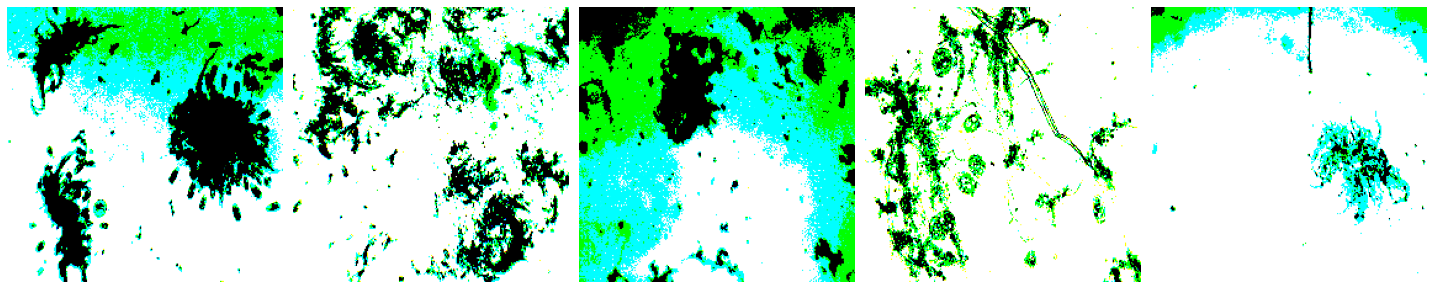

good [0. 1. 0.]
high [1. 0. 0.]
good [0. 1. 0.]
low [0. 0. 1.]
low [0. 0. 1.]


In [25]:
fig, axes = plt.subplots(1, 5, figsize = (20, 20))
axes = axes.flatten()
for images, ax in zip(imgs[5:10], axes):
    ax.imshow(images)
    ax.axis('off')
plt.tight_layout()
plt.show()
for x in labels[5:10]:
    if x[0] == 1:
        print('high ' + str(x) )
    if x[1] == 1:
        print('good ' + str(x) )
    if x[2] == 1:
        print('low ' + str(x) )

# THE MANUALLY MADE SIMPLE SEQUENTIAL CNN MODEL

There is a lot of flexibility in editting this model, as compared to the VGG16 model below

### Model Layer Description:

#### Conv2D layer: this is the convolutional layer of the neural network. The parameters:   
*filters* value is fairly arbitrary and can be played around with. Here we select 32 for the first convolutional layer and 64 for the second and 128 for the third.   
    It is good practice to increase the number of filters as the sequence goes on.   
   
*kernel_size* is often set to (3,3) for RGB 2D images. It is the window for the convolutional layer.   

*activation* 'relu' is a commonly used activation function   

*padding* is set to 'same' in order to output the same size data   

*input_shape* consists of the dimensions of the images followed by 3, which represents RGB   
   
   
#### MaxPooling2D: this layer pools the data (array) into smaller receptive fields and labels them by their maximum value. The parameters:
*pool_size* is the size of the receptive field. We have chosen a 2x2 field.   

*strides* determines the amount of shift from one receptive field to the next. We select 2 to cut the dimensions in half.

#### Flatten: this layer flattens the data to a 1D tensor


#### Dense: this layer reduces the classes to the amount of categories we have (i.e. 2 for high and good): The parameters
*units* is the amount of classes we want   

*activation* is the function that gives the probability for each corresponding output of the model. It is good practice to use the softmax function for 2 classes, but sigmoid is also good.   

In [27]:
simple_model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',
           input_shape = (im_size[0], im_size[1], 3)), 
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Flatten(),
    
    Dense(units = 3, activation = 'softmax')
])

### Here we have a summary of the layers of the model

In [28]:
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)           

### Prepare the model for training
We will be using the accuracy metric for obvious reasons. If accuracy on the training data is too high (i.e. 100%, we have likely overfit the model and hence the validation accuracy will be too low.   
The loss function is categorical_crossentropy because we want the code to be expanded to 3 classes in the future. However, binary_crossentropy also works for 2 classes if we change the activation function to sigmoid.

In [29]:
simple_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fitting the model
*x* is the input data   
*y* is not being selected because the data already has the specified labels from ImageDataGenerator, so we do not need target labels (y)  
*validation_data* is validation data   
*epochs* is the number of cycles through the training dataset. If the value is too high we risk overfitting and if it is too low we risk underfitting. We have selected 10 here.

In [30]:
simple_model.fit(x = train_batches, validation_data = validate_batches, epochs = 1, verbose = 2)


Epoch 1/1
 - 12s - loss: 16.7967 - accuracy: 0.3100 - val_loss: 18.1510 - val_accuracy: 0.3333


## Predicting Using the Model

In [31]:
simple_model_predictions = simple_model.predict(x = test_batches, verbose = 0)

In [32]:
#these are unshuffled as we saw when prepping the images
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [33]:
cm_simple_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(simple_model_predictions, axis = -1))

In [34]:
test_batches.class_indices

{'high': 0, 'good': 1, 'low': 2}

## Plotting the Confusion Matrix
True Labels vs Predicted Labels   
The diagonals represent the correct predictions

Confusion matrix, without normalization
[[12  5  3]
 [ 8  7  5]
 [ 6  6  8]]


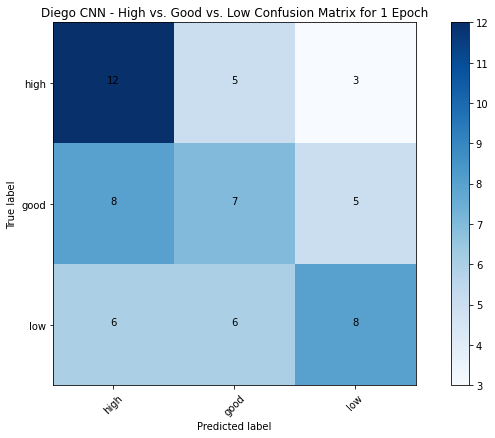

In [88]:
cm_plot_labels = ['high', 'good', 'low']
plot_confusion_matrix(cm = cm_simple_model, classes = cm_plot_labels, title = 'Simple CNN - High vs. Good vs. Low Confusion Matrix for 1 Epoch')

#### Test accuracy calculation
We have set 'high' as positive and 'good' as negative

In [89]:
high_correct = cm_simple_model[0][0]
high_incorrect = cm_simple_model[0][1] + cm_simple_model[0][2]
good_correct = cm_simple_model[1][1]
good_incorrect = cm_simple_model[1][0] + cm_simple_model[1][2]
low_correct = cm_simple_model[2][2]
low_incorrect = cm_simple_model[2][0] + cm_simple_model[2][1]


correct = cm_simple_model[0][0] + cm_simple_model[1][1] + cm_simple_model[2][2]
total = np.sum(cm_simple_model)

test_accuracy = (high_correct + good_correct + low_correct)/total
high_accuracy = high_correct/(high_correct + high_incorrect)
good_accuracy = good_correct/(good_correct + good_incorrect)
low_accuracy = low_correct/(low_correct + low_incorrect)


print("Total test accuracy: " + str(round(test_accuracy,2)))
print("High accuracy: " + str(round(high_accuracy,2)))
print("Good accuracy: " + str(round(good_accuracy,2)))
print("Low accuracy: " + str(round(low_accuracy,2)))


Total test accuracy: 0.45
High accuracy: 0.6
Good accuracy: 0.35
Low accuracy: 0.4


### SAVE THE MODEL WEIGHTS

In [41]:
simple_model.save_weights('simple_model_3_class_weights')

#model_20_3.save('split3_epochs20.h5')                 #this saves the full model, but the weights are enough
#del model_20_3                                        #to delete the model after saving it externally

### Loading the model weights
In order to bring back the weights from a saved model, we can use load_weights.    
STEPS:     
1) Recreate the structure of the sequential model    
2) Compile the reconstructed model     
3) Load the weights into the compiled model using model_name.load_weights(filename)    
4) The model is already fitted, so just insert the data you want to predict on


Additional information on saving/loading weights and models can be found here: https://www.tensorflow.org/guide/keras/save_and_serialize

In [42]:
simple_model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',
           input_shape = (im_size[0], im_size[1], 3)), 
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Flatten(),
    
    Dense(units = 2, activation = 'softmax')
])

loaded_test_model = Sequential()
for layer in simple_model.layers:
    loaded_test_model.add(layer)



#learning rate is 0.0001. This is the optimal 
loaded_test_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

loaded_test_model.load_weights('simple_model_3_class_weights')


In [43]:
loaded_test_predictions = loaded_test_model.predict(x = test_batches, verbose = 0)

In [ ]:
cm_loaded_test_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(loaded_test_predictions, axis = -1))
cm_plot_labels = ['high', 'good', 'low']
plot_confusion_matrix(cm = cm_loaded_test_model, classes = cm_plot_labels, title = 'High vs. Good vs. Low Confusion Matrix')


# Single function that runs all of simple model for 3 classes
Includes: creating model, compiling, fitting, predicting, producing confusion matrices, saving accuracy data to a text file as well as printing it and saves the weights.

In [122]:
def runAllSimple_3class(epochs, filename):
    
    simple_model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',
           input_shape = (im_size[0], im_size[1], 3)), 
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
        
    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Flatten(),
    
    Dense(units = 3, activation = 'softmax')])
    
    
    simple_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    simple_model.fit(x = train_batches, validation_data = validate_batches, epochs = epochs, verbose = 2)
    
    simple_model_predictions = simple_model.predict(x = test_batches, verbose = 0)
    
    cm_simple_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(simple_model_predictions, axis = -1))
    
    cm_plot_labels = ['high', 'good', 'low']
    plot_confusion_matrix(cm = cm_simple_model, classes = cm_plot_labels, title = 'Diego CNN - High vs. Good vs. Low Confusion Matrix for 1 Epoch')
    
    
    high_correct = cm_simple_model[0][0]
    high_incorrect = cm_simple_model[0][1] + cm_simple_model[0][2]
    good_correct = cm_simple_model[1][1]
    good_incorrect = cm_simple_model[1][0] + cm_simple_model[1][2]
    low_correct = cm_simple_model[2][2]
    low_incorrect = cm_simple_model[2][0] + cm_simple_model[2][1]


    correct = cm_simple_model[0][0] + cm_simple_model[1][1] + cm_simple_model[2][2]
    total = np.sum(cm_simple_model)

    test_accuracy = (high_correct + good_correct + low_correct)/total
    high_accuracy = high_correct/(high_correct + high_incorrect)
    good_accuracy = good_correct/(good_correct + good_incorrect)
    low_accuracy = low_correct/(low_correct + low_incorrect)


    print("Total test accuracy: " + str(round(test_accuracy,2)))
    print("High accuracy: " + str(round(high_accuracy,2)))
    print("Good accuracy: " + str(round(good_accuracy,2)))
    print("Low accuracy: " + str(round(low_accuracy,2)))

    
    
    with open('diego_3class_' + str(epochs) + 'epochs.txt', 'w') as f:
        f.write("Total test accuracy: " + str(round(test_accuracy,2)) + '\n')
        f.write("High accuracy: " + str(round(high_accuracy,2)) + '\n')
        f.write("Good accuracy: " + str(round(good_accuracy,2)) + '\n')
        f.write("Low accuracy: " + str(round(low_accuracy,2)) + '\n')
        f.write("Confusion matrix: " + str(cm_simple_model))
    f.close()
    
    simple_model.save_weights(filename)
    
    return vgg16_model, cm_vgg16_model

# Single function that loads a saved simple model for 3 classes. Also predicts with the loaded model
This function creates a VGG16 model, compiles it, loads the weights into it, performs predictions and produces a confusion matrix. The model and confusion matrix are returned.

In [77]:
def loading_model_simple(filename, trainable = False):
    
    loaded_simple_model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',
           input_shape = (im_size[0], im_size[1], 3)), 
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
        
    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    
    MaxPooling2D(pool_size = (2,2), strides = 2),
    
    Flatten(),
    
    Dense(units = 3, activation = 'softmax')])
    
    #learning rate is 0.0001. This is the optimal
    loaded_simple_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    loaded_simple_model.load_weights(filename)
    
    loaded_simple_model_predictions = loaded_simple_model.predict(x = test_batches, verbose = 0)
    
    cm_loaded_simple_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(loaded_simple_model_predictions, axis = -1))
    cm_plot_labels = ['high', 'good', 'low']
    plot_confusion_matrix(cm = cm_loaded_simple_model, classes = cm_plot_labels, title = 'Diego CNN - High vs. Good vs. Low Confusion Matrix')

    return loaded_simple_model, cm_loaded_simple_model

Epoch 1/10
 - 11s - loss: 74.0340 - accuracy: 0.3567 - val_loss: 53.0351 - val_accuracy: 0.3714
Epoch 2/10
 - 12s - loss: 17.9631 - accuracy: 0.4933 - val_loss: 13.5468 - val_accuracy: 0.4571
Epoch 3/10
 - 12s - loss: 2.9668 - accuracy: 0.7233 - val_loss: 6.2295 - val_accuracy: 0.5333
Epoch 4/10
 - 10s - loss: 0.7995 - accuracy: 0.8533 - val_loss: 6.0720 - val_accuracy: 0.5143
Epoch 5/10
 - 10s - loss: 1.0311 - accuracy: 0.8267 - val_loss: 9.1730 - val_accuracy: 0.4000
Epoch 6/10
 - 11s - loss: 0.3368 - accuracy: 0.9467 - val_loss: 1.7710 - val_accuracy: 0.3429
Epoch 7/10
 - 11s - loss: 0.1718 - accuracy: 0.9700 - val_loss: 6.8558 - val_accuracy: 0.4667
Epoch 8/10
 - 13s - loss: 0.0491 - accuracy: 0.9833 - val_loss: 7.3584 - val_accuracy: 0.4381
Epoch 9/10
 - 9s - loss: 0.0110 - accuracy: 0.9933 - val_loss: 7.1068 - val_accuracy: 0.4190
Epoch 10/10
 - 9s - loss: 4.1808e-04 - accuracy: 1.0000 - val_loss: 5.8135 - val_accuracy: 0.4190
Confusion matrix, without normalization
[[11  1  8]
 

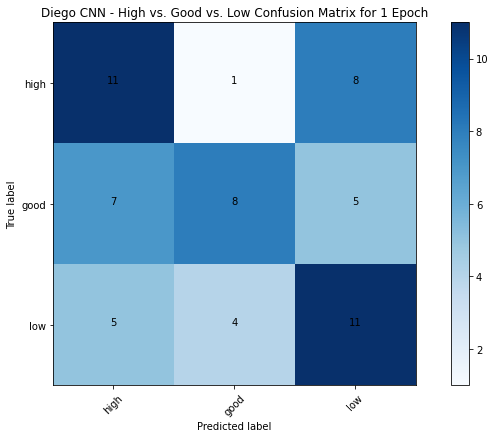

In [72]:
full_test_simple_loaded = runAllSimple_3class(10, 'full_test_simple_10epochs')

Confusion matrix, without normalization
[[11  1  8]
 [ 7  8  5]
 [ 5  4 11]]


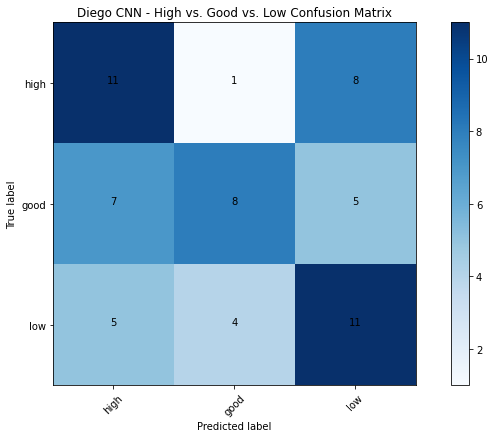

In [78]:
full_test_loaded_simple_model = loading_model_simple("full_test_simple_10epochs")

# THE VGG16 CNN MODEL

In [27]:
v_model = vgg16.VGG16()


#in order to change the shape of the image for the vgg16 model, uncomment the following line
#if image size is too large, the model may not have enough data to detect the fine structures
#presented, and more layers would have to be added.

#vgg16_model = VGG16(input_tensor=Input(shape=(128, 128, 3)))

In [28]:
vgg16_model = Sequential()
for layer in v_model.layers[:-1]:
    vgg16_model.add(layer)

We should see the same summary as above, but without the final layer (predictions)

In [29]:
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

By setting each layer.trainable as False or True, we are deciding whether we want the layer to re-train on our data. Because we have data that has not been seen by VGG16, we are going to keep each layer as trainable. Setting False freezes the weights of the layers.

In [30]:
#for layer in vgg16_model.layers:
#    layer.trainable = False

#### Now we add the layer that reduces this to 2 classes as the output

In [31]:
vgg16_model.add(Dense(units = 3, activation = 'softmax'))

Double check the summary to make sure the final layer has been added that only allows 2 classes as output. The number of parameters will also be reduced by this action.

In [32]:
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Here we train the VGG16 Model

In [33]:
#learning rate is 0.0001. This is the optimal 
vgg16_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
vgg16_model.fit(x = train_batches, validation_data = validate_batches, epochs = 1, verbose = 2)

Epoch 1/1
 - 241s - loss: 1.6593 - accuracy: 0.3900 - val_loss: 1.3968 - val_accuracy: 0.3238


## Predicting Using the Model

In [35]:
vgg16_model_predictions = vgg16_model.predict(x = test_batches, verbose = 0)

In [36]:
#these are unshuffled as we saw when prepping the images
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [37]:
cm_vgg16_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(vgg16_model_predictions, axis = -1))

In [38]:
test_batches.class_indices

{'high': 0, 'good': 1, 'low': 2}

## Plotting the Confusion Matrix
True Labels vs Predicted Labels   
The diagonals represent the correct predictions

Confusion matrix, without normalization
[[ 1 19  0]
 [ 0 20  0]
 [ 1 19  0]]


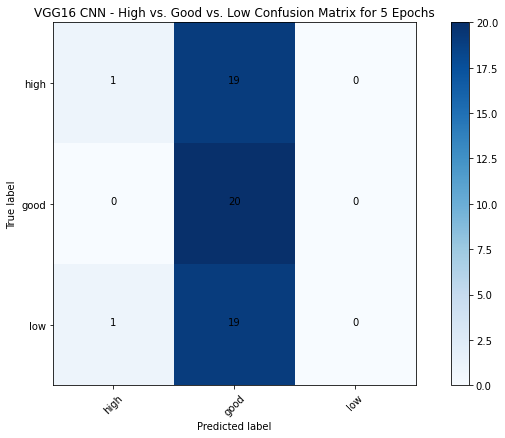

In [39]:
cm_plot_labels = ['high', 'good', 'low']
plot_confusion_matrix(cm = cm_vgg16_model, classes = cm_plot_labels, title = 'VGG16 CNN - High vs. Good vs. Low Confusion Matrix for 5 Epochs')

In [40]:
high_correct = cm_vgg16_model[0][0]
high_incorrect = cm_vgg16_model[0][1] + cm_vgg16_model[0][2]
good_correct = cm_vgg16_model[1][1]
good_incorrect = cm_vgg16_model[1][0] + cm_vgg16_model[1][2]
low_correct = cm_vgg16_model[2][2]
low_incorrect = cm_vgg16_model[2][0] + cm_vgg16_model[2][1]


correct = cm_simple_model[0][0] + cm_simple_model[1][1] + cm_simple_model[2][2]
total = np.sum(cm_simple_model)

test_accuracy = (high_correct + good_correct + low_correct)/total
high_accuracy = high_correct/(high_correct + high_incorrect)
good_accuracy = good_correct/(good_correct + good_incorrect)
low_accuracy = low_correct/(low_correct + low_incorrect)


print("Total test accuracy: " + str(round(test_accuracy,2)))
print("High accuracy: " + str(round(high_accuracy,2)))
print("Good accuracy: " + str(round(good_accuracy,2)))
print("Low accuracy: " + str(round(low_accuracy,2)))


Total test accuracy: 0.35
High accuracy: 0.05
Good accuracy: 1.0
Low accuracy: 0.0


# Single function that runs all of VGG16 for 3 classes
Includes: creating model, compiling, fitting, predicting, producing confusion matrices, saving accuracy data to a text file as well as printing it and saves the weights.

In [53]:
def runAllVGG16_3class(epochs, filename):
    vgg16_model = Sequential()
    
    for layer in v_model.layers[:-1]:
        vgg16_model.add(layer)
        
    vgg16_model.add(Dense(units = 3, activation = 'softmax'))
    
    #learning rate is 0.0001. This is the optimal 
    vgg16_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    vgg16_model.fit(x = train_batches, validation_data = validate_batches, epochs = epochs, verbose = 2)
    
    vgg16_model_predictions = vgg16_model.predict(x = test_batches, verbose = 0)
    
    cm_vgg16_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(vgg16_model_predictions, axis = -1))
    
    cm_plot_labels = ['high', 'good', 'low']
    plot_confusion_matrix(cm = cm_vgg16_model, classes = cm_plot_labels, title = 'High vs. Good vs. Low Confusion Matrix')
    
    high_correct = cm_vgg16_model[0][0]
    high_incorrect = cm_vgg16_model[0][1] + cm_vgg16_model[0][2]
    good_correct = cm_vgg16_model[1][1]
    good_incorrect = cm_vgg16_model[1][0] + cm_vgg16_model[1][2]
    low_correct = cm_vgg16_model[2][2]
    low_incorrect = cm_vgg16_model[2][0] + cm_vgg16_model[2][1]


    correct = cm_vgg16_model[0][0] + cm_vgg16_model[1][1] + cm_vgg16_model[2][2]
    total = np.sum(cm_vgg16_model)

    test_accuracy = (high_correct + good_correct + low_correct)/total
    high_accuracy = high_correct/(high_correct + high_incorrect)
    good_accuracy = good_correct/(good_correct + good_incorrect)
    low_accuracy = low_correct/(low_correct + low_incorrect)


    print("Total test accuracy: " + str(round(test_accuracy,2)))
    print("High accuracy: " + str(round(high_accuracy,2)))
    print("Good accuracy: " + str(round(good_accuracy,2)))
    print("Low accuracy: " + str(round(low_accuracy,2)))
    
    
    with open('vgg16_3class_' + str(epochs) + 'epochs.txt', 'w') as f:
        f.write("Total test accuracy: " + str(round(test_accuracy,2)) + '\n')
        f.write("High accuracy: " + str(round(high_accuracy,2)) + '\n')
        f.write("Good accuracy: " + str(round(good_accuracy,2)) + '\n')
        f.write("Low accuracy: " + str(round(low_accuracy,2)) + '\n')
        f.write("Confusion matrix: " + str(cm_vgg16_model))
    f.close()
    
    vgg16_model.save_weights(filename)
    
    return vgg16_model, cm_vgg16_model

# Single function that loads a saved VGG16 model for 3 classes. Also predicts with the loaded model
This function creates a VGG16 model, compiles it, loads the weights into it, performs predictions and produces a confusion matrix. The model and confusion matrix are returned.

In [67]:
def loading_model_vgg16(filename, trainable = False):
    v_model = vgg16.VGG16()

    loaded_model = Sequential()
    for layer in v_model.layers[:-1]:
        loaded_model.add(layer)

    #trainable should be true if the original model had the weights as trainable
    if trainable == True:
        for layer in vgg16_model.layers:
            layer.trainable = False

    loaded_model.add(Dense(units = 3, activation = 'softmax'))

    #learning rate is 0.0001. This is the optimal
    loaded_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    loaded_model.load_weights(filename)
    
    loaded_model_predictions = loaded_model.predict(x = test_batches, verbose = 0)
    
    cm_loaded_model = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(loaded_model_predictions, axis = -1))
    cm_plot_labels = ['high', 'good', 'low']
    plot_confusion_matrix(cm = cm_loaded_model, classes = cm_plot_labels, title = 'VGG16 CNN - High vs. Good vs. Low Confusion Matrix')

    return loaded_model, cm_loaded_model

Epoch 1/10
 - 224s - loss: 1.2935 - accuracy: 0.2633 - val_loss: 1.1438 - val_accuracy: 0.3333
Epoch 2/10
 - 213s - loss: 1.1548 - accuracy: 0.3867 - val_loss: 1.1398 - val_accuracy: 0.3238
Epoch 3/10
 - 225s - loss: 1.1907 - accuracy: 0.3400 - val_loss: 1.2647 - val_accuracy: 0.3238
Epoch 4/10
 - 216s - loss: 1.1453 - accuracy: 0.4000 - val_loss: 1.1460 - val_accuracy: 0.3333
Epoch 5/10
 - 217s - loss: 1.0313 - accuracy: 0.4300 - val_loss: 0.7096 - val_accuracy: 0.4190
Epoch 6/10
 - 217s - loss: 1.0034 - accuracy: 0.4600 - val_loss: 1.5403 - val_accuracy: 0.4286
Epoch 7/10
 - 246s - loss: 1.1476 - accuracy: 0.4133 - val_loss: 0.7465 - val_accuracy: 0.3714
Epoch 8/10
 - 236s - loss: 1.0430 - accuracy: 0.4167 - val_loss: 0.9677 - val_accuracy: 0.4571
Epoch 9/10
 - 227s - loss: 1.0127 - accuracy: 0.4733 - val_loss: 0.5956 - val_accuracy: 0.4667
Epoch 10/10
 - 213s - loss: 0.9109 - accuracy: 0.5200 - val_loss: 0.6386 - val_accuracy: 0.5048
Confusion matrix, without normalization
[[10  6  

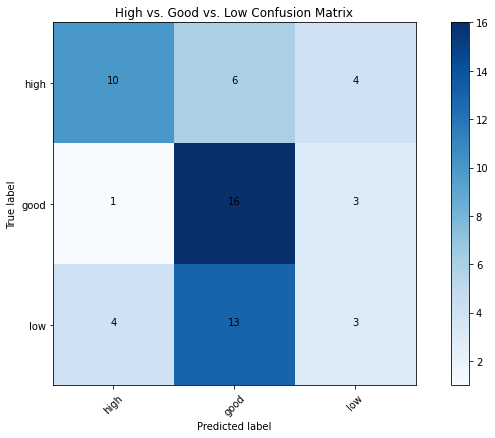

In [54]:
full_test_run = runAllVGG16_3class(10, "full_test_10epochs")
full_test_run_model = full_test_run[0]
full_test_run_cm = full_test_run[1]

Confusion matrix, without normalization
[[10  6  4]
 [ 1 16  3]
 [ 4 13  3]]


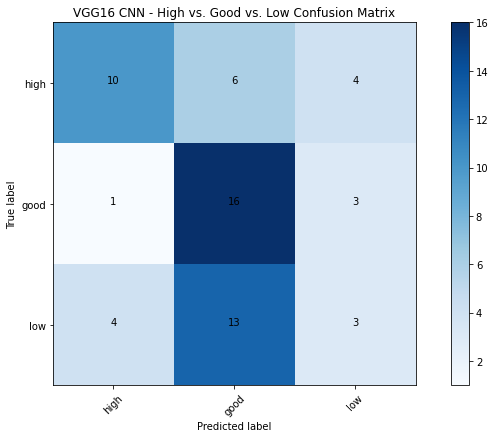

In [68]:
full_test_loaded_model = loading_model_vgg16("full_test_10epochs")